# Implementation of a Devito acoustic Least-square Reverse time migration - *JUDI*

In [63]:
using JUDI, PyPlot, LinearAlgebra, ImageFiltering, ColorSchemes, Random

## Model

In [3]:
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
o = (0., 0.);  # What is the location of the top left corner. This is necessary to define

## Velocity [km/s]

In [4]:
v = 1.5f0 * ones(Float32, n)
v[:, 31:66] .= 1.5f0 + 0.5f0
v[:, 66:end] .= 1.5f0 + 1.5f0
v[41:61, 36:56] .= 1.5f0 + 1.0f0;
# Create initial model and smooth the boundaries
v0 = imfilter(v, Kernel.gaussian((5,5)));

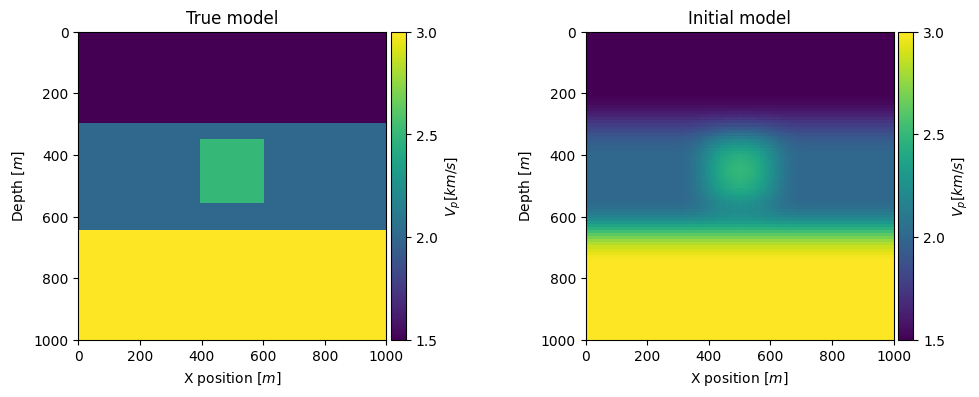

In [11]:
figure(figsize=(12,4));
subplot(121)
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"X position $[m]$")
ylabel(L"Depth $[m]$")
title("True model")
subplot(122)
im = imshow(v0', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"X position $[m]$")
ylabel(L"Depth $[m]$")
title("Initial model");

## Reflectivity

In [8]:
dm_true = (v .^ (-2) .- v0 .^ (-2));

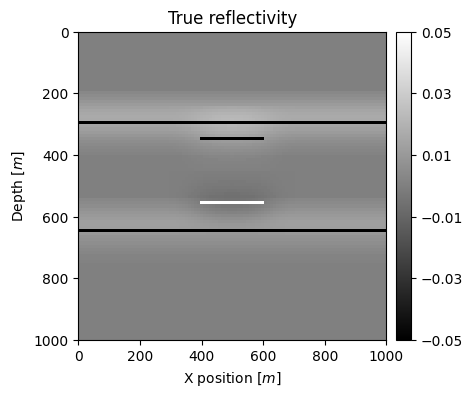

PyObject Text(0.5, 1.0, 'True reflectivity')

In [9]:
figure(figsize=(12,4));
im = imshow(diff(dm_true, dims=2)', cmap="gray", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0], vmin=-.05, vmax=.05)
cb = colorbar(im, ticks=-0.05:0.02:0.05, pad=0.01)
#cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"X position $[m]$")
ylabel(L"Depth $[m]$")
title("True reflectivity")

In [13]:
# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m0 - m);

# Setup model structure
nsrc = 21	# number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0);

## Acquisition geometry

In [15]:
# Set up receiver geometry
nxrec = 101
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0 # WE have to set the y coordiante to zero (or any number) for 2D modeling
zrec = range(30f0, stop=30f0, length=nxrec)

# receiver sampling and recording time
timeD = 1000f0   # receiver recording time [ms]
dtD = 2f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

GeometryIC{Float32} wiht 21 sources


In [16]:
xsrc = convertToCell(range(0f0, stop=(n[1]-1)*d[1], length=nsrc))
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(30f0, stop=30f0, length=nsrc))

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 21 sources


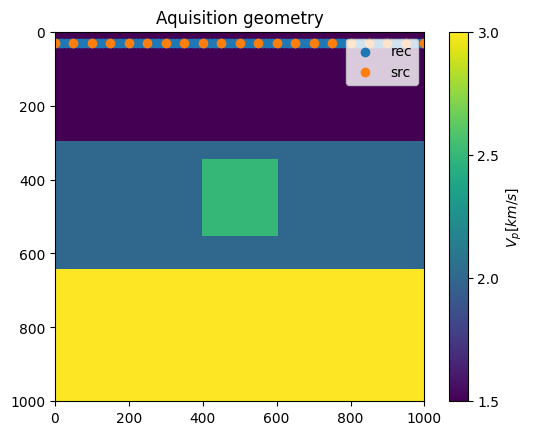

In [135]:
figure();
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
scatter(xrec, zrec, label="rec")
scatter(xsrc, zsrc, label=:src)
cb = colorbar(im, ticks=unique(v))
cb[:set_label](label = L"$V_p [km/s]$")
title("Aquisition geometry")
legend(loc="upper right");

In [30]:
# setup wavelet
f0 = 0.025f0     # kHz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [31]:
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing

JUDIOptions(8, false, false, 1000.0, false, "", "shot", false, true, Any[], "as", 1, 1, false, nothing, 0.015f0)

In [61]:
ntComp = get_computational_nt(q.geometry,dD.geometry,model0)	# no. of computational time steps
info = Info(prod(model0.n),dD.nsrc,ntComp)

Info(10201, 21, Integer[794, 794, 794, 794, 794, 794, 794, 794, 794, 794  …  794, 794, 794, 794, 794, 794, 794, 794, 794, 794])

In [58]:
# Setup operators
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)

## Synthetic data

In [33]:
# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q

Building forward operator
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran 

judiVector{Float32, Matrix{Float32}} with 21 sources


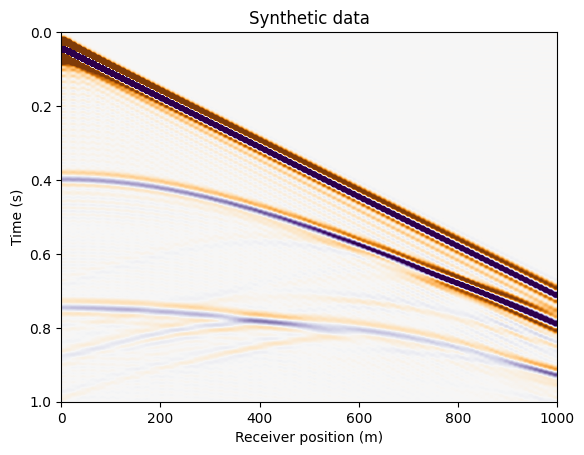

PyObject Text(0.5, 1.0, 'Synthetic data')

In [44]:
fig = figure()
imshow(dobs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Receiver position (m)")
ylabel("Time (s)")
title("Synthetic data")

## Adjoint


In [35]:
qad = Ps*adjoint(F)*adjoint(Pr)*dobs

Building forward operator
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s
Operator `adjoint` ran in 0.04 s


judiVector{Float32, Matrix{Float32}} with 21 sources


In [46]:
dm = vec(model0.m - model.m);

In [48]:
# Linearized modeling J*dm
dD = J*dm
# Adjoint jacobian, RTM image
rtm = adjoint(J)*dD

Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Building adjoint born operator


PhysicalParameter{Float32} of size (101, 101) with origin (0.0, 0.0) and spacing (10.0, 10.0)


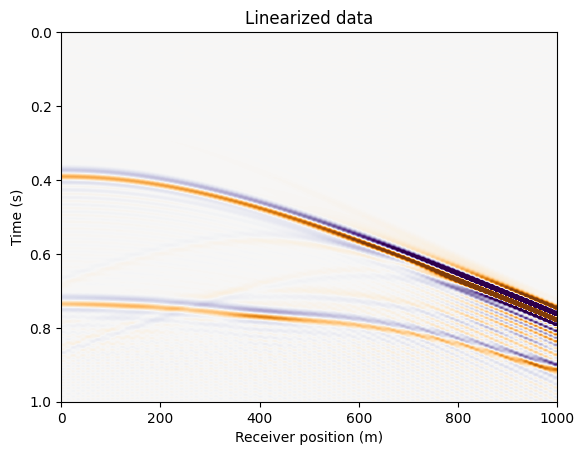

PyObject Text(0.5, 1.0, 'Linearized data')

In [49]:
fig = figure()
imshow(dD.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Receiver position (m)")
ylabel("Time (s)")
title("Linearized data")

In [84]:
# Right-hand preconditioners (model topmute)
Mr = judiTopmute(model0; taperwidth=10)	# mute up to grid point 52, with 10 point taper
# Left-hand side preconditioners
Ml = judiDataMute(q.geometry, dD.geometry; t0=.120)	# data topmute starting at time 120ms

# Stochastic gradient
x = zeros(Float32, info.n)	# zero initial guess
batchsize = 10	# use subset of 10 shots per iteration
niter = 30
fval = zeros(Float32, niter)

for j=1:niter
	println("Iteration: ", j)
	# Select batch and set up left-hand preconditioner
	i = randperm(dD.nsrc)[1:batchsize]

	# Compute residual and gradient
	r = Ml[i]*J[i]*Mr*x - Ml[i]*dD[i]
	g = adjoint(Mr)*adjoint(J[i])*adjoint(Ml[i])*r

	# Step size and update variable
	fval[j] = .5f0*norm(r)^2
	t = norm(r)^2/norm(g)^2
	global x -= t*g
end

Iteration: 1
Iteration: 2


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 3


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 4


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s


Iteration: 5


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 6


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 7


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 8


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 9


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s


Iteration: 10


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 11


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 12


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 13


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 14


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 15


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 16


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 17


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 18


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 19


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 20


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.11 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 21


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s


Iteration: 22


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 23


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 24


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.10 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 25


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 26


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s


Iteration: 27


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 28


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


Iteration: 29


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.10 s
Operator `born` ran in 0.11 s
Operator `born` ran in 0.11 s


Iteration: 30


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI ~/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s


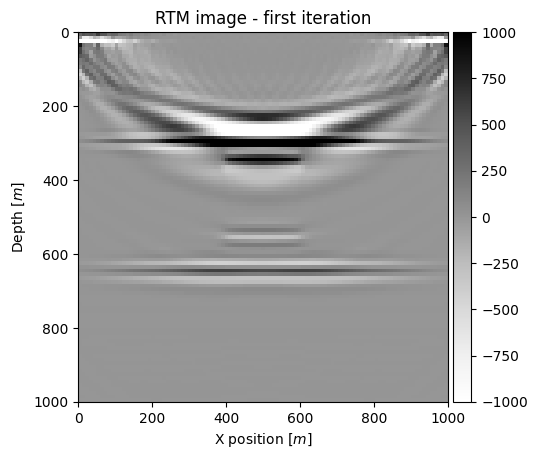

PyObject Text(0.5, 1.0, 'RTM image - first iteration')

In [143]:
figure();
im = imshow(diff(rtm.data, dims=2)', cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0], vmin=-1e3, vmax=1e3)
cb = colorbar(im, pad=0.01)
#cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"X position $[m]$")
ylabel(L"Depth $[m]$")
title("RTM image - first iteration")

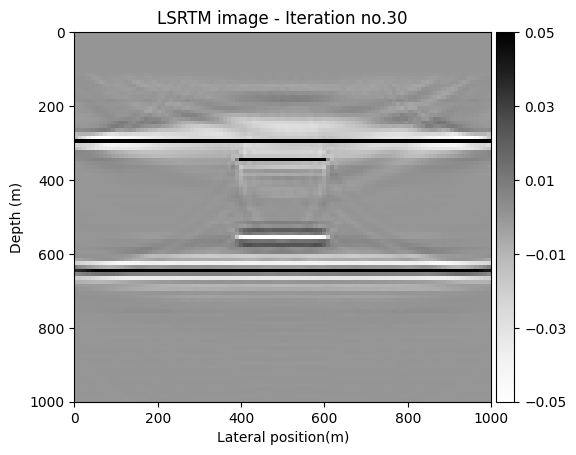

PyObject Text(0.5, 1.0, 'LSRTM image - Iteration no.30')

In [127]:
fig = figure()
im = imshow(diff(x.data, dims=2)', vmin=-0.05, vmax=0.05, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.05:0.02:0.05)
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("LSRTM image - Iteration no.30")

____

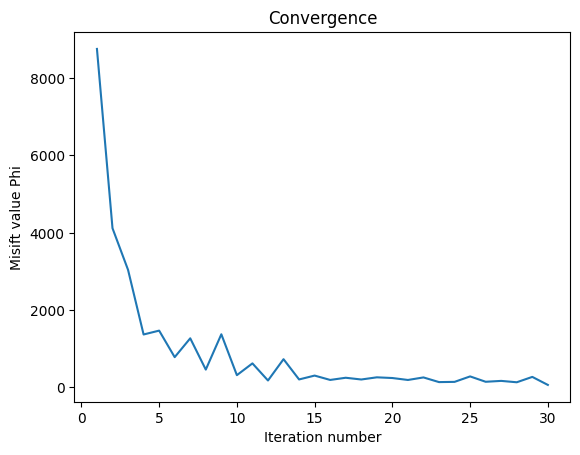

PyObject Text(0.5, 1.0, 'Convergence')

In [119]:
fig = figure()
xax = 1:1:30
plot(xax,fval)
xlabel("Iteration number")
ylabel("Misift value Phi")
title("Convergence")

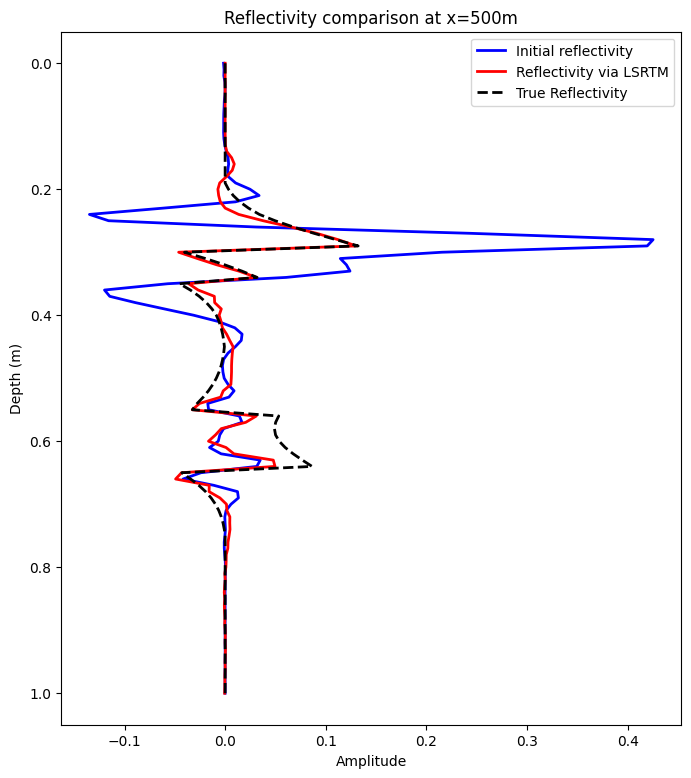

PyObject Text(0.5, 1.0, 'Reflectivity comparison at x=500m')

In [144]:
fig = figure(figsize=(8,9))
xax = 0:0.01:1
plot(-rtm[50,:]./1e4, xax, linewidth=2, label="Initial reflectivity", "b")
plot(-x[50,:], xax, linewidth=2, label="Reflectivity via LSRTM", "r")
plot(dm_true[50,:], xax, linewidth=2, label="True Reflectivity", "k--")
legend()
gca().invert_yaxis()
xlabel("Amplitude")
ylabel("Depth (m)")
title("Reflectivity comparison at x=500m")